In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 从 scikit-learn 库中，导入我们需要的“工具”
from sklearn.feature_extraction.text import TfidfTransformer # <-- 【新】导入TF-IDF工具
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

N_CLUSTERS = 6  # 我们希望把卡组分成一些原型
RANDOM_STATE = 42 # 确保每次运行结果都一样

print("所有库导入成功！")

所有库导入成功！


In [2]:
print("\n--- 步骤1: 加载数据 ---")

# 加载你的CSV数据
file_path = 'data/20250501_to_20250731_corp_data.csv'
try:
    corp_df = pd.read_csv(file_path)
    print(f"✅ 成功加载 {len(corp_df)} 条卡牌记录。")
except FileNotFoundError:
    print(f"❌ 错误: 未在'{file_path}'找到文件。请检查文件名和路径。")
    # 如果文件不存在，后面的代码会出错，所以我们在这里处理一下
    corp_df = pd.DataFrame()


--- 步骤1: 加载数据 ---
✅ 成功加载 9680 条卡牌记录。


In [3]:
if not corp_df.empty:
    print("\n--- 步骤2: 特征工程 ---")
    
    # 我们只关心'decklist_id', 'title'和'quantity'这三列
    # 并且，我们要排除掉身份卡本身，因为它对于区分构筑类型没有帮助
    deck_data = corp_df[corp_df['type_code'] != 'identity'][['decklist_id', 'title', 'quantity']]

    # 使用 pivot_table 将“长数据”变成“宽数据”
    # index='decklist_id': 每一行代表一个独立的卡组
    # columns='title': 每一列代表一张独一无二的卡牌
    # values='quantity': 表格中的值是这张卡在那个卡组里的数量
    # fill_value=0: 如果一个卡组里没有某张卡，就用0来填充
    deck_matrix = deck_data.pivot_table(index='decklist_id', columns='title', values='quantity', fill_value=0)

    print("✅ “卡组-卡牌”矩阵创建成功！")
    print(f"矩阵维度: {deck_matrix.shape[0]} 套卡组, {deck_matrix.shape[1]} 种不同的卡牌。")
    # print(deck_matrix.head()) # 你可以取消这行注释，来查看矩阵的前几行



--- 步骤2: 特征工程 ---
✅ “卡组-卡牌”矩阵创建成功！
矩阵维度: 307 套卡组, 251 种不同的卡牌。


In [4]:
if 'deck_matrix' in locals():
    print("\n--- 步骤3: 应用TF-IDF权重 ---")

    # a. 初始化TF-IDF转换器
    tfidf_transformer = TfidfTransformer()

    # b. 在你的原始计数矩阵上，应用TF-IDF转换
    #    fit_transform() 会计算每张卡的IDF值，然后乘以TF值，得到最终的TF-IDF分数
    tfidf_matrix_sparse = tfidf_transformer.fit_transform(deck_matrix)

    # c. (可选但推荐) 将稀疏矩阵转回Pandas DataFrame，方便后续解读
    #    toarray()会把它变成一个普通的二维数组
    tfidf_df = pd.DataFrame(
        tfidf_matrix_sparse.toarray(), 
        columns=deck_matrix.columns, 
        index=deck_matrix.index
    )

    print("✅ TF-IDF权重应用完成！")
    # print(tfidf_df[['Hedge Fund', 'Spin Doctor', 'Biotic Labor']].head()) # 你可以取消注释来验证一下


--- 步骤3: 应用TF-IDF权重 ---
✅ TF-IDF权重应用完成！


In [5]:
if 'tfidf_df' in locals():
    print("\n--- 步骤4: 基于TF-IDF数据进行标准化与K-Means聚类 ---")

    # a. 数据标准化 (在TF-IDF矩阵上进行)
    scaler = StandardScaler()
    scaled_tfidf_matrix = scaler.fit_transform(tfidf_df)

    # b. K-Means聚类
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
    cluster_labels = kmeans.fit_predict(scaled_tfidf_matrix)

    # c. 将分类结果添加回我们的TF-IDF数据和原始计数数据中，方便解读
    tfidf_df['cluster'] = cluster_labels
    deck_matrix['cluster'] = cluster_labels # 也加到原始矩阵里
    
    print("✅ K-Means聚类完成！")
    print("\n各原型的卡组数量分布:")
    print(tfidf_df['cluster'].value_counts())


--- 步骤4: 基于TF-IDF数据进行标准化与K-Means聚类 ---
✅ K-Means聚类完成！

各原型的卡组数量分布:
cluster
1    156
2     53
0     47
4     38
5     11
3      2
Name: count, dtype: int64


D:\ProgramFiles\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



--- 步骤5: PCA降维与可视化 ---


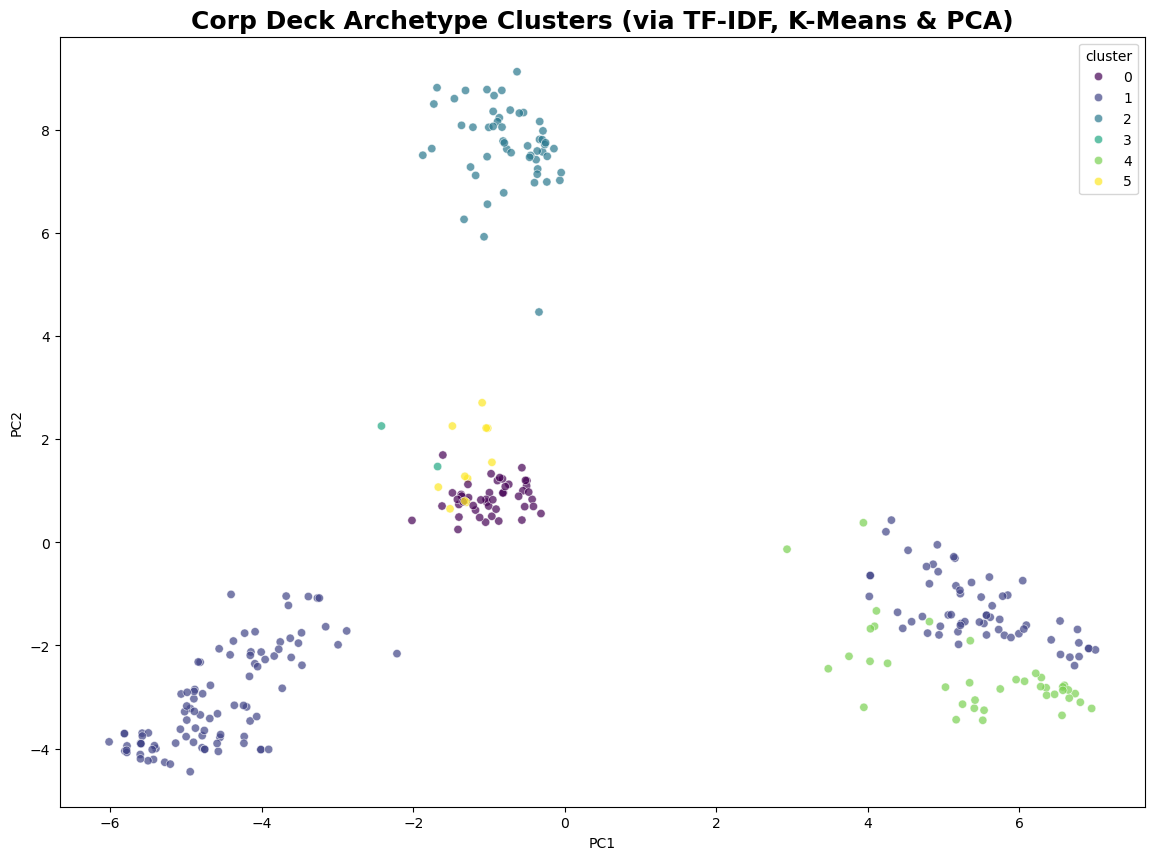

In [6]:
if 'scaled_tfidf_matrix' in locals():
    print("\n--- 步骤5: PCA降维与可视化 ---")
    
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    # 在标准化后的TF-IDF数据上进行降维
    reduced_data = pca.fit_transform(scaled_tfidf_matrix)

    pca_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2'])
    pca_df['cluster'] = cluster_labels

    plt.figure(figsize=(14, 10))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis', alpha=0.7)
    plt.title('Corp Deck Archetype Clusters (via TF-IDF, K-Means & PCA)', fontsize=18, weight='bold')
    plt.show()

In [7]:
if 'tfidf_df' in locals():
    print("\n--- 步骤6: 解读新的原型含义 (基于TF-IDF分数) ---")
    
    # 现在，我们应该看每个簇里，哪些卡牌的【平均TF-IDF分数】最高
    # 这能告诉我们哪些是真正定义了这个原型的“关键张”
    for i in range(N_CLUSTERS):
        print(f"\n--- 原型 Cluster #{i} 的核心卡牌 (by TF-IDF score) ---")
        cluster_tfidf = tfidf_df[tfidf_df['cluster'] == i].drop(columns=['cluster'])
        print(cluster_tfidf.mean().sort_values(ascending=False).head(10))


--- 步骤6: 解读新的原型含义 (基于TF-IDF分数) ---

--- 原型 Cluster #0 的核心卡牌 (by TF-IDF score) ---
title
Brân 1.0                 0.184532
Project Ingatan          0.180455
Offworld Office          0.179812
Humanoid Resources       0.161009
M.I.C.                   0.160903
Tranquility Home Grid    0.156170
Bumi 1.0                 0.153131
Mercia B4LL4RD           0.138661
Seamless Launch          0.136368
Drafter                  0.136119
dtype: float64

--- 原型 Cluster #1 的核心卡牌 (by TF-IDF score) ---
title
Fujii Asset Retrieval      0.126395
Petty Cash                 0.124054
Cohort Guidance Program    0.113019
Anemone                    0.109092
Hansei Review              0.106935
Phật Gioan Baotixita       0.106848
Sting!                     0.102988
Spin Doctor                0.099816
Tatu-Bola                  0.097954
Moon Pool                  0.096663
dtype: float64

--- 原型 Cluster #2 的核心卡牌 (by TF-IDF score) ---
title
Your Digital Life       0.193576
Embedded Reporting      0.192598
Ping     

In [8]:
# ==============================================================================
# 单元格 7: 解读增强 - 分析每个Cluster最常用的身份(Identity)
# ==============================================================================
# 假设 corp_df_merged 和 deck_matrix (带有'cluster'列) 已经存在

print("\n--- 步骤6: 分析每个原型的核心身份 ---")

# 1. 首先，我们从我们完整的长数据表格中，筛选出所有的身份卡
#    这会给我们一个包含 'decklist_id', 'title' (身份卡标题), 'faction_code' 的新表格
corp_identities_df = corp_df[corp_df['type_code'] == 'identity'][['decklist_id', 'title', 'faction_code']]

# 2. 我们需要把每个decklist_id对应的cluster标签，添加到上面这个身份表格中
#    deck_matrix 的索引就是 decklist_id，所以我们可以直接用它
cluster_labels_series = deck_matrix['cluster']
corp_identities_with_cluster = corp_identities_df.merge(
    cluster_labels_series,
    left_on='decklist_id',
    right_index=True # 使用 deck_matrix 的索引进行合并
)

# 3. 现在，我们来分组计算每个cluster里，各个identity title出现的次数
print("\n每个原型(Cluster)中，使用率最高的Top 3身份：\n")

# 使用 groupby 和 value_counts
identity_counts_by_cluster = corp_identities_with_cluster.groupby('cluster')['title'].value_counts()

# 4. 为了更清晰地展示结果，我们写一个循环来打印
# .unique() 会得到所有的cluster标签，.sort()确保按0,1,2,3,4的顺序打印
for cluster_id in sorted(corp_identities_with_cluster['cluster'].unique()):
    print(f"--- Cluster #{cluster_id} Top Identities ---")
    
    # 从我们计算好的结果中，筛选出当前cluster的Top 3
    top_3 = identity_counts_by_cluster[cluster_id].head(3)
    
    # 计算这个cluster的总卡组数，用于算比例
    total_decks_in_cluster = (corp_identities_with_cluster['cluster'] == cluster_id).sum()
    
    for identity_title, count in top_3.items():
        percentage = (count / total_decks_in_cluster) * 100
        print(f"  - {identity_title}: {count} decks ({percentage:.1f}%)")
    print("-" * 30)


--- 步骤6: 分析每个原型的核心身份 ---

每个原型(Cluster)中，使用率最高的Top 3身份：

--- Cluster #0 Top Identities ---
  - LEO Construction: Labor Solutions: 22 decks (40.7%)
  - Haas-Bioroid: Precision Design: 19 decks (35.2%)
  - Poétrï Luxury Brands: All the Rage: 8 decks (14.8%)
------------------------------
--- Cluster #1 Top Identities ---
  - AU Co.: The Gold Standard in Clones: 99 decks (45.6%)
  - Nuvem SA: Law of the Land: 35 decks (16.1%)
  - The Zwicky Group: Invisible Hands: 26 decks (12.0%)
------------------------------
--- Cluster #2 Top Identities ---
  - Nebula Talent Management: Making Stars: 50 decks (68.5%)
  - Pravdivost Consulting: Political Solutions: 12 decks (16.4%)
  - Epiphany Analytica: Nations Undivided: 8 decks (11.0%)
------------------------------
--- Cluster #3 Top Identities ---
  - Ampère: Cybernetics For Anyone: 2 decks (100.0%)
------------------------------
--- Cluster #4 Top Identities ---
  - Ob Superheavy Logistics: Extract. Export. Excel.: 48 decks (92.3%)
  - BANGUN: 

In [9]:

# --- 步骤1: 【分】(Divide) - 筛选出目标ID的所有卡组 ---
target_identity_title = 'AU Co.: The Gold Standard in Clones'
print(f"\n--- 正在对 '{target_identity_title}' 进行深度亚型分析 ---")

# a. 找出所有使用这个ID的decklist_id
au_co_deck_ids = corp_identities_with_cluster[
    corp_identities_with_cluster['title'] == target_identity_title
]['decklist_id']

# b. 从我们最原始的【长数据】表格中，把这些卡组的所有卡牌都提取出来
au_co_cards_df = corp_df[corp_df['decklist_id'].isin(au_co_deck_ids)]
print(f"找到了 {len(au_co_deck_ids)} 套 '{target_identity_title}' 卡组进行分析。")


# --- 步骤2: 【治】(Conquer) - 构建、加权并聚类 ---

# a. 构建只包含AU Co.卡组的“卡组-卡牌”【原始计数】矩阵
au_co_deck_data = au_co_cards_df[au_co_cards_df['type_code'] != 'identity'][['decklist_id', 'title', 'quantity']]
au_co_deck_matrix_raw = au_co_deck_data.pivot_table(index='decklist_id', columns='title', values='quantity', fill_value=0)

# --- 步骤 2.5: 【关键修正】在这里应用“专家知识加权” ---
print("\n--- 正在应用专家知识权重 ---")

# a. 定义你认为能够区分AU Co.不同流派的关键牌
au_co_key_cards = [
    'See How They Run',
    'Oppo Research', # Corrected spelling from 'Reasearch'
    'The Holo Man',
    'Bladderwort'
]

# b. 创建权重字典，给关键牌更高的权重 (e.g., 10x)
weights = {card: 100.0 if card in au_co_key_cards else 1.0 for card in au_co_deck_matrix_raw.columns}

# c. 应用权重，生成【加权后】的矩阵
weighted_au_co_matrix = au_co_deck_matrix_raw * pd.Series(weights)
print("✅ 专家权重应用完成！")


# --- 步骤3: 在【加权后】的数据上进行标准化与聚类 ---
print("\n--- 正在基于【加权后】的数据进行聚类 ---")

N_SUB_CLUSTERS = 3 # 我们仍然假设AU Co.内部主要有两种主流变体
scaler = StandardScaler()
# 【关键修正】对加权后的矩阵进行标准化
scaled_weighted_matrix = scaler.fit_transform(weighted_au_co_matrix)

kmeans = KMeans(n_clusters=N_SUB_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
# 【关键修正】在加权并标准化的数据上进行聚类
sub_cluster_labels = kmeans.fit_predict(scaled_weighted_matrix)

# d. 将亚型标签添加回【原始】矩阵中，方便我们用【原始数量】来解读
au_co_deck_matrix_raw['sub_cluster'] = sub_cluster_labels


# --- 步骤4: 解读新的亚型 ---
print("\n--- 正在解读 '{target_identity_title}' 的内部亚型 (基于专家加权) ---")
print("AU Co. 内部亚型样本量分布:")
print(au_co_deck_matrix_raw['sub_cluster'].value_counts())

for i in range(N_SUB_CLUSTERS):
    print(f"\n--- 亚型 Sub-Cluster #{i} 的核心卡牌 (按原始数量) ---")
    sub_cluster_cards = au_co_deck_matrix_raw[au_co_deck_matrix_raw['sub_cluster'] == i].drop(columns=['sub_cluster'])
    # 我们依然看【原始的平均数量】，这样结果更直观
    print(sub_cluster_cards.mean().sort_values(ascending=False).head(15))


--- 正在对 'AU Co.: The Gold Standard in Clones' 进行深度亚型分析 ---
找到了 99 套 'AU Co.: The Gold Standard in Clones' 卡组进行分析。

--- 正在应用专家知识权重 ---
✅ 专家权重应用完成！

--- 正在基于【加权后】的数据进行聚类 ---

--- 正在解读 '{target_identity_title}' 的内部亚型 (基于专家加权) ---
AU Co. 内部亚型样本量分布:
sub_cluster
1    41
2    27
0     2
Name: count, dtype: int64

--- 亚型 Sub-Cluster #0 的核心卡牌 (按原始数量) ---
title
Phật Gioan Baotixita       3.0
Spin Doctor                3.0
See How They Run           3.0
Tatu-Bola                  3.0
Fujii Asset Retrieval      3.0
Anemone                    2.5
Byte!                      2.5
Hansei Review              2.5
La Costa Grid              2.5
Cohort Guidance Program    2.0
Blood in the Water         1.5
Mindscaping                1.5
Charlotte Caçador          1.5
Reaper Function            1.5
Hedge Fund                 1.5
dtype: float64

--- 亚型 Sub-Cluster #1 的核心卡牌 (按原始数量) ---
title
Fujii Asset Retrieval      2.975610
Cohort Guidance Program    2.951220
Petty Cash                 2.902439
Hansei Rev

D:\ProgramFiles\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- 正在对Au.co亚型进行PCA降维与可视化 ---
✅ Au.co亚型聚类可视化图表生成成功！


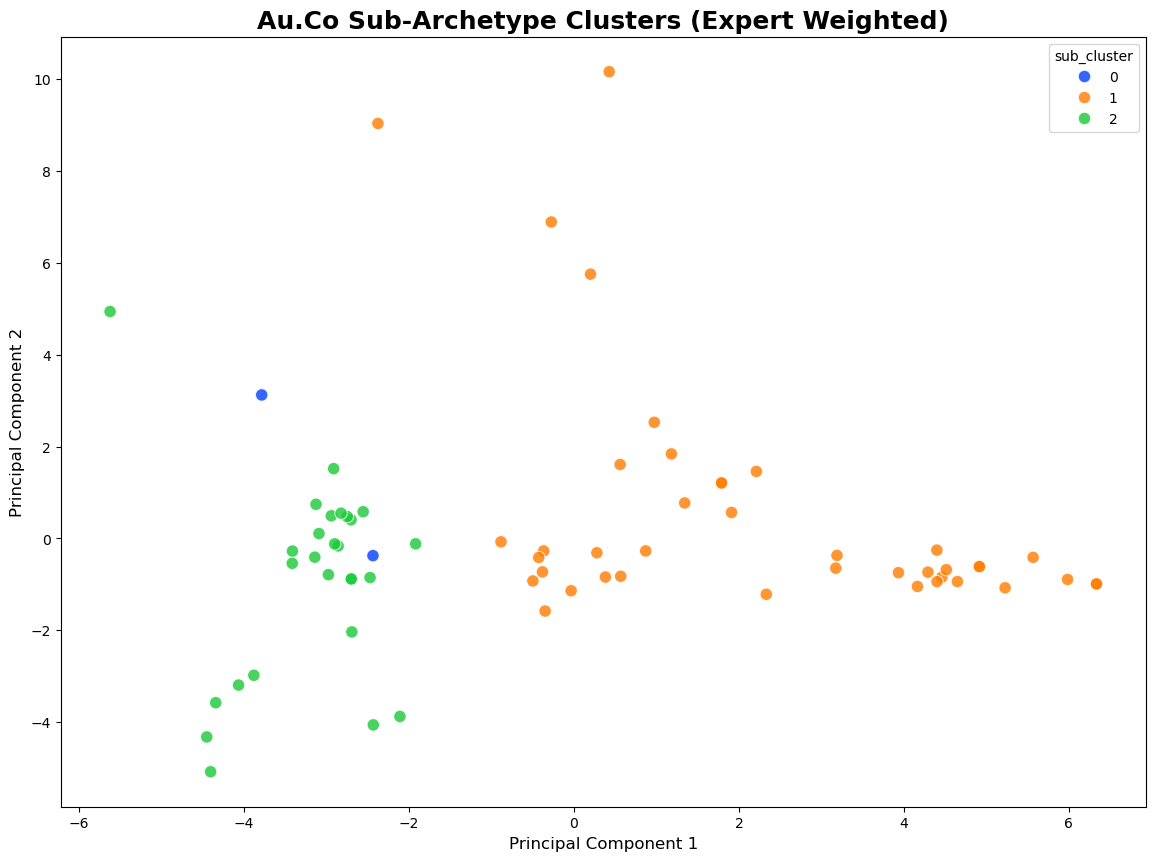

In [10]:
print("\n--- 正在对Au.co亚型进行PCA降维与可视化 ---")

# 1. 初始化PCA降维模型
#    我们将把高维的卡牌空间压缩到只有2个维度
pca_au_co = PCA(n_components=2, random_state=RANDOM_STATE)

# 2. 在我们用于聚类的【加权并标准化后】的数据上进行降维
reduced_au_co_data = pca_au_co.fit_transform(scaled_weighted_matrix)

# 3. 创建一个新的DataFrame用于绘图
pca_au_co_df = pd.DataFrame(data=reduced_au_co_data, columns=['PC1', 'PC2'])
pca_au_co_df['sub_cluster'] = sub_cluster_labels # 加上我们得到的亚型标签

# 4. 使用Seaborn的scatterplot进行可视化
plt.figure(figsize=(14, 10))
au_co_cluster_plot = sns.scatterplot(
    data=pca_au_co_df,
    x='PC1',
    y='PC2',
    hue='sub_cluster', # <-- 让点的颜色根据我们分出的亚型(0, 1, 2)来决定
    palette='bright',  # 换一个鲜艳的调色板，方便区分
    s=80,              # s参数可以调整点的大小，让它们更清晰
    alpha=0.8          # 设置透明度
)

au_co_cluster_plot.set_title("Au.Co Sub-Archetype Clusters (Expert Weighted)", fontsize=18, weight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

print("✅ Au.co亚型聚类可视化图表生成成功！")
plt.show()

In [11]:


print("\n--- 正在对比 AU Co. 各亚型的核心构筑 ---")

# 使用 groupby() 来同时计算每个簇的平均卡牌数量
mean_cards_per_cluster = au_co_deck_matrix_raw.groupby('sub_cluster').mean()

# 逐一打印每个簇的Top 15核心卡牌
for cluster_id in mean_cards_per_cluster.index:
    print(f"\n--- 亚型 Sub-Cluster #{cluster_id} 的核心卡牌 Top 15 ---")
    
    # 从计算好的结果中，筛选出当前簇的数据并排序
    top_cards = mean_cards_per_cluster.loc[cluster_id].sort_values(ascending=False).head(15)
    print(top_cards)


--- 正在对比 AU Co. 各亚型的核心构筑 ---

--- 亚型 Sub-Cluster #0 的核心卡牌 Top 15 ---
title
Phật Gioan Baotixita       3.0
Spin Doctor                3.0
See How They Run           3.0
Tatu-Bola                  3.0
Fujii Asset Retrieval      3.0
Anemone                    2.5
Byte!                      2.5
Hansei Review              2.5
La Costa Grid              2.5
Cohort Guidance Program    2.0
Blood in the Water         1.5
Mindscaping                1.5
Charlotte Caçador          1.5
Reaper Function            1.5
Hedge Fund                 1.5
Name: 0, dtype: float64

--- 亚型 Sub-Cluster #1 的核心卡牌 Top 15 ---
title
Fujii Asset Retrieval      2.975610
Cohort Guidance Program    2.951220
Petty Cash                 2.902439
Hansei Review              2.878049
Phật Gioan Baotixita       2.804878
Anemone                    2.707317
Spin Doctor                2.658537
Moon Pool                  2.487805
Tatu-Bola                  2.390244
Regenesis                  2.219512
Sting!                     2.


--- Cluster 1 vs. Cluster 2 的最具区分度卡牌 ---

【Cluster 1 比 Cluster 2 带得更多的卡 (正值越大越显著):】
title
Hansei Review       2.322493
Hedge Fund          1.780488
Boto                1.534779
Regenesis           1.367660
Scatter Field       1.365854
Tatu-Bola           0.982836
Hybrid Release      0.920506
Longevity Serum     0.570009
Project Yagi-Uda    0.560976
Petty Cash          0.532069
dtype: float64

【Cluster 2 比 Cluster 1 带得更多的卡 (负值越小越显著):】
title
Bladderwort            -2.597109
Reaper Function        -1.979223
Blood in the Water     -1.830172
Semak-samun            -1.367660
Mindscaping            -1.037940
Hostile Architecture   -0.979223
Oppo Research          -0.777778
Wage Workers           -0.691960
See How They Run       -0.669377
Sting!                 -0.582656
dtype: float64


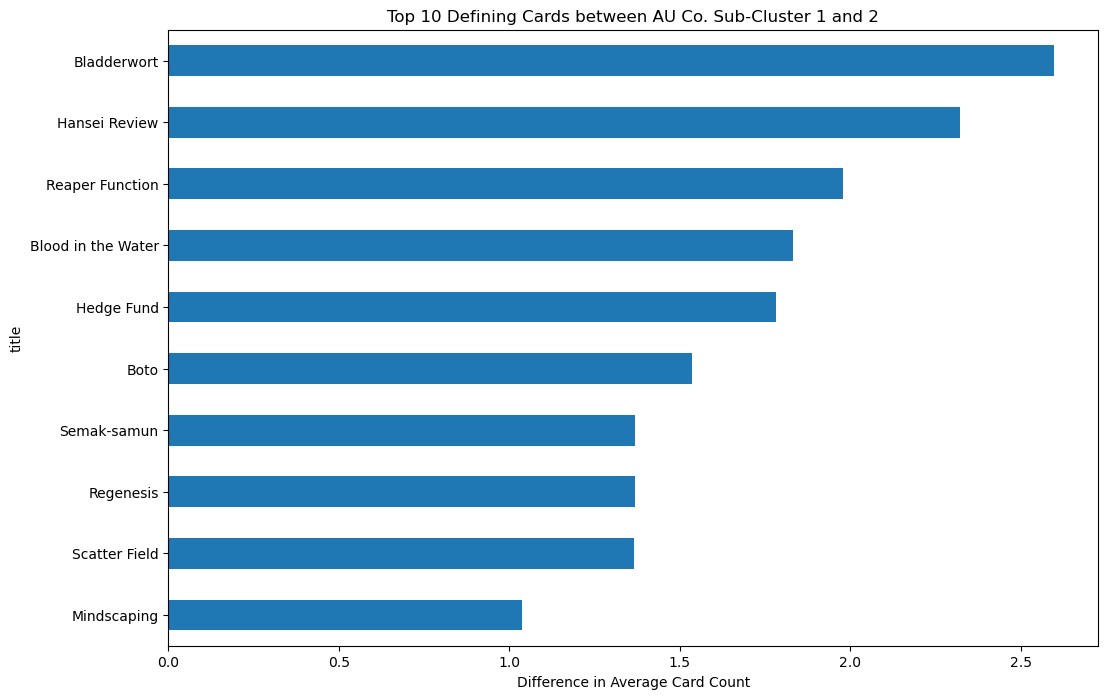

In [12]:


# 对比 Cluster 1 和 Cluster 2
cluster_1_vector = mean_cards_per_cluster.loc[1]
cluster_2_vector = mean_cards_per_cluster.loc[2]

# 直接用向量相减，得到差异向量
diff_vector = cluster_1_vector - cluster_2_vector

# 找出差异最大的卡牌 (包括正向和负向)
print("\n--- Cluster 1 vs. Cluster 2 的最具区分度卡牌 ---")

print("\n【Cluster 1 比 Cluster 2 带得更多的卡 (正值越大越显著):】")
print(diff_vector.sort_values(ascending=False).head(10))

print("\n【Cluster 2 比 Cluster 1 带得更多的卡 (负值越小越显著):】")
print(diff_vector.sort_values(ascending=True).head(10))

# 可视化这个差异
plt.figure(figsize=(12, 8))
# 我们只画出差异最显著的Top 10卡牌
diff_vector.abs().sort_values(ascending=False).head(10).sort_values().plot(kind='barh')
plt.title('Top 10 Defining Cards between AU Co. Sub-Cluster 1 and 2')
plt.xlabel('Difference in Average Card Count')
plt.show()

✅ 图表已成功保存到: images/Au_Co_archetype_popularity.png


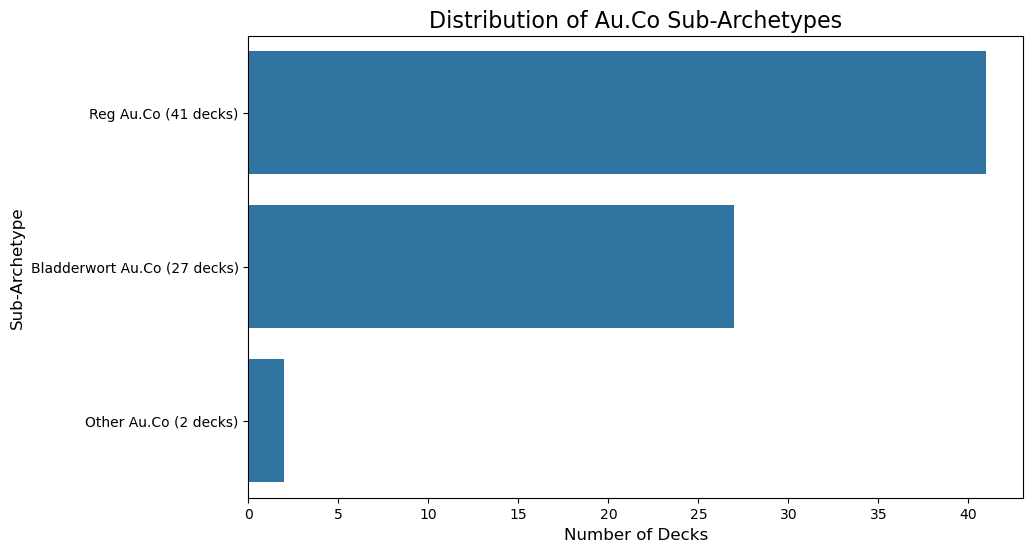

In [13]:
# 1. 计算每个亚型的样本量
sub_cluster_counts = au_co_deck_matrix_raw['sub_cluster'].value_counts()

# (可选) 我们来给这些数字起个更有意义的名字
sub_cluster_names = {
    0: 'Other Au.Co (2 decks)',
    1: 'Reg Au.Co (41 decks)',
    2: 'Bladderwort Au.Co (27 decks)'
}
sub_cluster_counts.index = sub_cluster_counts.index.map(sub_cluster_names)


# 2. 绘制水平条形图
plt.figure(figsize=(10, 6))
sns.barplot(
    x=sub_cluster_counts.values,
    y=sub_cluster_counts.index,
    orient='h' # orient='h' 明确告诉seaborn这是水平条形图
)

plt.title('Distribution of Au.Co Sub-Archetypes', fontsize=16)
plt.xlabel('Number of Decks', fontsize=12)
plt.ylabel('Sub-Archetype', fontsize=12)

image_path = 'images/Au_Co_archetype_popularity.png'

# 使用 plt.savefig() 命令进行保存
# 几个常用参数的解释：
#   - dpi=300: 设置图片的分辨率(dots per inch)。300是一个很好的高质量标准，让图片更清晰。
#   - bbox_inches='tight': 自动裁剪掉图表周围多余的白边，让图片更紧凑美观。
plt.savefig(image_path, dpi=300, bbox_inches='tight')

print(f"✅ 图表已成功保存到: {image_path}")

plt.show()

In [15]:


# --- 步骤1: 【分】(Divide) - 筛选出目标ID的所有卡组 ---
target_identity_title = 'Ob Superheavy Logistics: Extract. Export. Excel.'
print(f"\n--- 正在对 '{target_identity_title}' 进行深度亚型分析 ---")

# a. 找出所有使用这个ID的decklist_id
ob_deck_ids = corp_identities_with_cluster[
    corp_identities_with_cluster['title'] == target_identity_title
]['decklist_id']

# b. 从我们最原始的【长数据】表格中，把这些卡组的所有卡牌都提取出来
ob_cards_df = corp_df[corp_df['decklist_id'].isin(ob_deck_ids)]
print(f"找到了 {len(ob_deck_ids)} 套 '{target_identity_title}' 卡组进行分析。")


# --- 步骤2: 【治】(Conquer) - 在这个【子集】上重复我们的机器学习流程 ---

# a. 构建只包含Ob卡组的“卡组-卡牌”计数矩阵
ob_deck_data = ob_cards_df[ob_cards_df['type_code'] != 'identity'][['decklist_id', 'title', 'quantity']]
ob_deck_matrix_raw = ob_deck_data.pivot_table(index='decklist_id', columns='title', values='quantity', fill_value=0)

# --- 步骤2.5: 【关键修正】在这里应用“专家知识加权” ---
print("\n--- 正在应用专家知识权重 ---")

# a. 定义你认为能够区分Ob不同流派的关键牌
ob_key_cards = [
    'Humanoid Resources',
    'Hostile Architecture',
    'The Holo Man',
    'Bladderwort',
    'Mutually Assured Destruction'
]

# b. 创建权重字典，给关键牌更高的权重 (比如10倍)
weights = {card: 1.0 if card in ob_key_cards else 1.0 for card in ob_deck_matrix_raw.columns}

# c. 应用权重，生成【加权后】的矩阵
weighted_ob_matrix = ob_deck_matrix_raw * pd.Series(weights)
print("✅ 专家权重应用完成！")


# --- 步骤3: 在【加权后】的数据上进行标准化与聚类 ---
print("\n--- 正在基于【加权后】的数据进行聚类 ---")

N_SUB_CLUSTERS = 3 # 我们可以先假设Ob有3种主流变体
scaler = StandardScaler()
# 【关键修正】对加权后的矩阵进行标准化
scaled_weighted_matrix = scaler.fit_transform(weighted_ob_matrix)

kmeans = KMeans(n_clusters=N_SUB_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
# 【关键修正】在加权并标准化的数据上进行聚类
sub_cluster_labels = kmeans.fit_predict(scaled_weighted_matrix)

# d. 将亚型标签添加回【原始】矩阵中，方便我们用【原始数量】来解读
ob_deck_matrix_raw['sub_cluster'] = sub_cluster_labels


# --- 步骤4: 解读新的亚型 ---
print("\n--- 正在解读 '{target_identity_title}' 的内部亚型 (基于专家加权) ---")
print("Ob Superheavy Logistics 内部亚型样本量分布:")
print(ob_deck_matrix_raw['sub_cluster'].value_counts())

for i in range(N_SUB_CLUSTERS):
    print(f"\n--- 亚型 Sub-Cluster #{i} 的核心卡牌 (按原始数量) ---")
    sub_cluster_cards = ob_deck_matrix_raw[ob_deck_matrix_raw['sub_cluster'] == i].drop(columns=['sub_cluster'])
    # 我们依然看【原始的平均数量】，这样结果更直观
    print(sub_cluster_cards.mean().sort_values(ascending=False).head(15))


--- 正在对 'Ob Superheavy Logistics: Extract. Export. Excel.' 进行深度亚型分析 ---
找到了 50 套 'Ob Superheavy Logistics: Extract. Export. Excel.' 卡组进行分析。

--- 正在应用专家知识权重 ---
✅ 专家权重应用完成！

--- 正在基于【加权后】的数据进行聚类 ---

--- 正在解读 '{target_identity_title}' 的内部亚型 (基于专家加权) ---
Ob Superheavy Logistics 内部亚型样本量分布:
sub_cluster
1    18
0    16
2     2
Name: count, dtype: int64

--- 亚型 Sub-Cluster #0 的核心卡牌 (按原始数量) ---
title
Extract                        3.0000
Spin Doctor                    2.9375
Anthill Excavation Contract    2.6250
Azef Protocol                  2.6250
Maskirovka                     2.5625
SDS Drone Deployment           2.1875
Stavka                         2.0000
Hedge Fund                     1.8125
Off the Books                  1.5625
Cybersand Harvester            1.4375
Mavirus                        1.3125
Kessleroid                     1.2500
Envelopment                    1.2500
Humanoid Resources             1.1875
Eminent Domain                 1.1875
dtype: float64

--- 亚型 Sub-Clust

D:\ProgramFiles\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- 正在对Ob亚型进行PCA降维与可视化 ---
✅ Ob亚型聚类可视化图表生成成功！


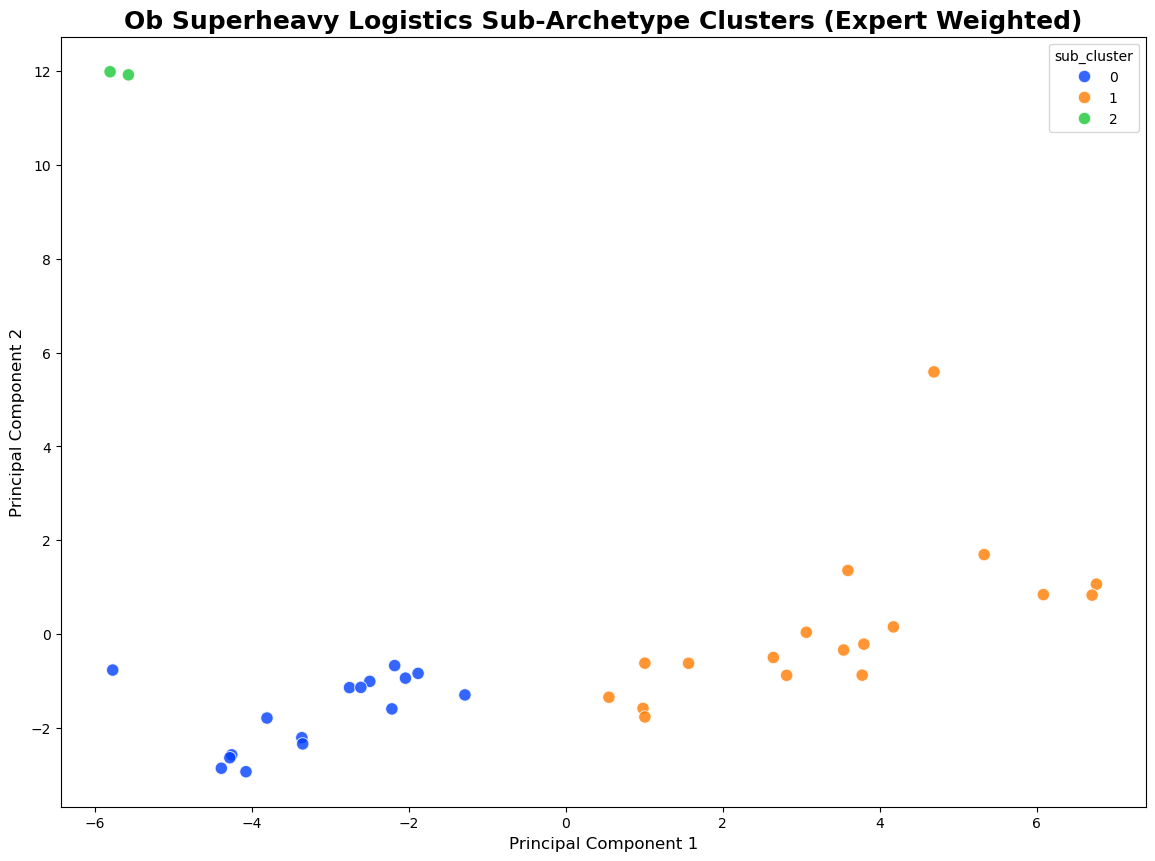

In [16]:


print("\n--- 正在对Ob亚型进行PCA降维与可视化 ---")

# 1. 初始化PCA降维模型
#    我们将把高维的卡牌空间压缩到只有2个维度
pca_ob = PCA(n_components=2, random_state=RANDOM_STATE)

# 2. 在我们用于聚类的【加权并标准化后】的数据上进行降维
reduced_ob_data = pca_ob.fit_transform(scaled_weighted_matrix)

# 3. 创建一个新的DataFrame用于绘图
pca_ob_df = pd.DataFrame(data=reduced_ob_data, columns=['PC1', 'PC2'])
pca_ob_df['sub_cluster'] = sub_cluster_labels # 加上我们得到的亚型标签

# 4. 使用Seaborn的scatterplot进行可视化
plt.figure(figsize=(14, 10))
ob_cluster_plot = sns.scatterplot(
    data=pca_ob_df,
    x='PC1',
    y='PC2',
    hue='sub_cluster', # <-- 让点的颜色根据我们分出的亚型(0, 1, 2)来决定
    palette='bright',  # 换一个鲜艳的调色板，方便区分
    s=80,              # s参数可以调整点的大小，让它们更清晰
    alpha=0.8          # 设置透明度
)

ob_cluster_plot.set_title("Ob Superheavy Logistics Sub-Archetype Clusters (Expert Weighted)", fontsize=18, weight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

print("✅ Ob亚型聚类可视化图表生成成功！")
plt.show()

✅ 图表已成功保存到: images/ob_archetype_popularity.png


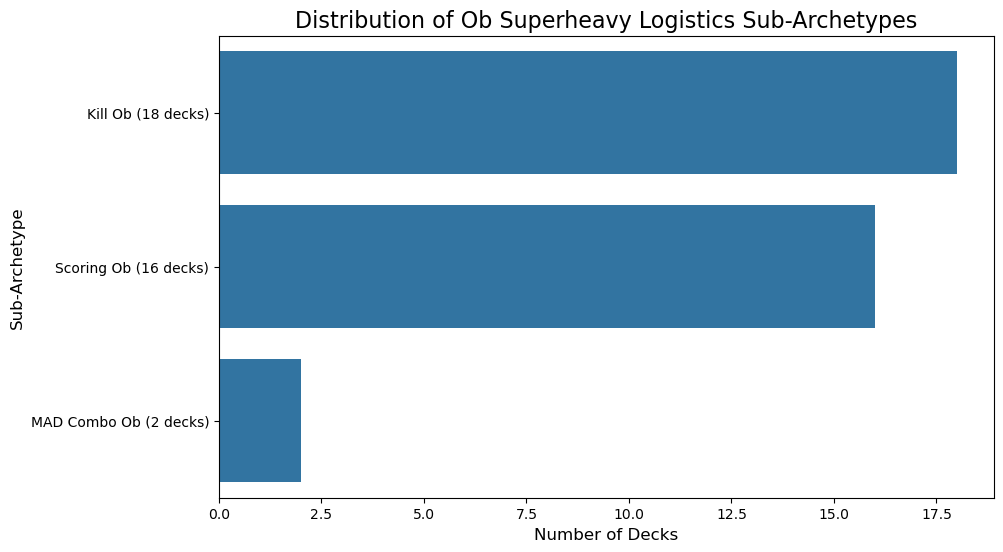

In [17]:
# 假设 ob_deck_matrix_raw 已经有了 'sub_cluster' 列

# 1. 计算每个亚型的样本量
sub_cluster_counts = ob_deck_matrix_raw['sub_cluster'].value_counts()

# (可选) 我们来给这些数字起个更有意义的名字
sub_cluster_names = {
    0: 'Scoring Ob (16 decks)',
    1: 'Kill Ob (18 decks)',
    2: 'MAD Combo Ob (2 decks)'
}
sub_cluster_counts.index = sub_cluster_counts.index.map(sub_cluster_names)


# 2. 绘制水平条形图
plt.figure(figsize=(10, 6))
sns.barplot(
    x=sub_cluster_counts.values,
    y=sub_cluster_counts.index,
    orient='h' # orient='h' 明确告诉seaborn这是水平条形图
)

plt.title('Distribution of Ob Superheavy Logistics Sub-Archetypes', fontsize=16)
plt.xlabel('Number of Decks', fontsize=12)
plt.ylabel('Sub-Archetype', fontsize=12)

image_path = 'images/ob_archetype_popularity.png'

# 使用 plt.savefig() 命令进行保存
# 几个常用参数的解释：
#   - dpi=300: 设置图片的分辨率(dots per inch)。300是一个很好的高质量标准，让图片更清晰。
#   - bbox_inches='tight': 自动裁剪掉图表周围多余的白边，让图片更紧凑美观。
plt.savefig(image_path, dpi=300, bbox_inches='tight')

print(f"✅ 图表已成功保存到: {image_path}")

plt.show()